# Text classification 
## Sentiment analysis
It is a natural language processing problem where text is understood and the underlying intent is predicted. Here, you need to  predict the sentiment of movie reviews as either positive or negative in Python using the Keras deep learning library.

## Data description
The dataset is the Large Movie Review Dataset often referred to as the IMDB dataset.

The [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) (often referred to as the IMDB dataset) contains 25,000 highly polar movie reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given moving review has a positive or negative sentiment.  Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).

## Loading dataset
First, we will load complete dataset and analyze some properties of it.<br>


In [2]:
import numpy as np
from matplotlib import pyplot
import numpy
import keras
from keras import regularizers,layers
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [3]:
# np.load is used inside imdb.load_data. But imdb.load_data still assumes the default 
# values of an older version of numpy. So necessary changes to np.load are made

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load Numpy
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [4]:
# call load_data with allow_pickle implicitly set to true
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

print(X.shape)
print(X_train.shape)
print(y.shape)
print(y_train.shape)

(50000,)
(25000,)
(50000,)
(25000,)


## **Let's see some of reviews.**

In [5]:
word_to_id = keras.datasets.imdb.get_word_index()
id_to_word = {value:key for key,value in word_to_id.items()}
for i in range(15,20):
  print("********************************************")
  print(' '.join(id_to_word.get(id - 3, '?')for id in X_train[i] ))

********************************************
? a total waste of time just throw in a few explosions non stop fighting exotic cars a deranged millionaire slow motion computer generated car crashes and last but not least a hugh ? like character with wall to wall hot babes and mix in a ? and you will have this sorry excuse for a movie i really got a laugh out of the dr evil like heavily ? compound the plot was somewhere between preposterous and non existent how many ? are willing to make a 25 million dollar bet on a car race answer 4 but didn't they become ? through ? responsibility this was written for ? males it plays like a video game i did enjoy the ? ii landing in the desert though
********************************************
? laputa castle in the sky is the bomb the message is as strong as his newer works and more pure fantastic and flying pirates how could it be any better the art is totally amazing and the soundtrack which is ? many times after this im not sure if this was the fi

## Summarize the data
1) Find out the number of classes in label (*y* array)? <br>
2) Find out number of unique words in dataset *X*?  <br>
3) Calculate the list of review length , report mean and standard deviation. <br>

In [6]:
def summarize_data():
  """
  Output:
                    classes: list, list of unique classes in y  
                no_of_words: int, number of unique words in dataset x 
     list_of_review_lengths: list,  list of lengths of each review 
         mean_review_length: float, mean(list_of_review_lengths), a single floating point value
          std_review_length: float, standard_deviation(list_of_review_lengths), a single floating point value
  """
  import statistics
  classes = np.unique(y)
  no_of_words = len(np.unique(np.concatenate(X)))
  list_of_review_lengths = [len(i) for i in X]
  mean_review_length = statistics.mean(list_of_review_lengths)
  std_review_length = statistics.stdev(list_of_review_lengths)
  return classes, no_of_words, list_of_review_lengths, mean_review_length, std_review_length


classes, no_of_words, list_of_review_lengths, mean_review_length, std_review_length = summarize_data()


In [8]:
print(len(y))

50000


## One hot encode the output data

In [9]:
def one_hot(y):
  """
  Inputs:
    y: numpy array with class labels
  Outputs:
    y_oh: numpy array with corresponding one-hot encodings
  """
  #y_oh = np.zeros(len(classes))
  oh = []
  for i in range(0, len(y)):
    if y[i] == 0:
      oh.append([1, 0])
    else:
      oh.append([0, 1]) 
  y_oh = np.array(oh)
  return y_oh
y_train = one_hot(y_train)
y_test = one_hot(y_test)

In [10]:
print(y_train[0])

[0 1]


### Multi-hot encode the input data

All sequences are of different length and our vocabulory size is 10K.  <br>
**To Do**<br>
1) Intialize vector of dimension 10,000 with value 0. <br>
2) For those tokens in a sequence which are present in Vocabulary make that position as 1 and keep all other positions filled with 0. <br>
For example, lets take Vocabulary = ['I': 0, ':1, 'eat: 2:' mango: 3, 'fruit':4, 'happy':5, 'you':6] <br>
We have two sequnces and 
Multi-hot encoding of both sequences will be of dimension:  7 (vocab size).<br>
1) *Mango is my favourite fruit* becomes *Mango ? ? ? fruit* after removing words which are not in my vocabulary. Hence multi hot encoding will have two 1's corresponding to mango and fruit i.e, [0, 0, 0, 1, 1, 0, 0] <br>
Similarly, <br>
  2) *I love to eat mango*  = *I ? ? eat mango*  =  [1, 1, 0, 1, 0, 0, 0]

In [11]:
def multi_hot_encode(sequences, dimension):
  """
    Input:
          sequences: list of sequences in X_train or X_test

    Output:
          results: mult numpy matrix of shape(len(sequences), dimension)
                  
  """
  results = np.zeros((len(sequences), dimension))
  for i in range(len(sequences)):
    for j in range(len(sequences[i])):
      results[i][sequences[i][j]] = 1
  return results


In [12]:
x_train = multi_hot_encode(X_train, 10000)
x_test = multi_hot_encode(X_test, 10000)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)
print(x_train)

x_train  (25000, 10000)
x_test  (25000, 10000)
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


## Split the data into train and validation

In [14]:
from sklearn.model_selection import train_test_split
x_strat, x_dev, y_strat, y_dev = train_test_split(x_train, y_train,test_size=0.40,random_state=0, stratify=y_train)

## Build Model
Build a multi layered feed forward network in keras. 

### Create the model

In [15]:
def create_model():
    """
    Output:
        model: A compiled keras model
    """
    # change the model According to you if you want
    model = Sequential()
    model.add(Embedding(10000, 32, input_length = 10000))
    model.add(Flatten())
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model
  
model = create_model()
print(model.summary())

W0731 23:35:39.832265 20460 deprecation_wrapper.py:119] From C:\Users\Akash\Anaconda3\envs\rootenv\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 23:35:44.392634 20460 deprecation_wrapper.py:119] From C:\Users\Akash\Anaconda3\envs\rootenv\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 23:35:45.880326 20460 deprecation_wrapper.py:119] From C:\Users\Akash\Anaconda3\envs\rootenv\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 23:35:48.160502 20460 deprecation_wrapper.py:119] From C:\Users\Akash\Anaconda3\envs\rootenv\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0731 23:35:48.232724 20460 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10000, 32)         320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 320000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                10240032  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 10,560,098
Trainable params: 10,560,098
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
#x_strat.shape
X_train.shape

(25000,)

In [17]:
x_strat.shape

(15000, 10000)

In [18]:
y_strat.shape

(15000, 2)

In [19]:
x_dev.shape

(10000, 10000)

In [20]:
y_dev.shape

(10000, 2)

In [23]:
x_test.shape

(25000, 10000)

In [24]:
y_test.shape

(25000, 2)

### Fit the Model

In [25]:
import matplotlib.pyplot as plt
def fit(model):
    """
    Action:
        Fit the model created above using training data as x_strat and y_strat
        and validation_data as x_dev and y_dev, verbose=2 and store it in 'history' variable.
        
        evaluate the model using x_test, y_test, verbose=0 and store it in 'scores' list
    Output:
        scores: list of length 2
        history_dict: output of history.history where history is output of model.fit()
    """
   
    history = model.fit(x_strat, y_strat, validation_data=(x_dev, y_dev), epochs=15, batch_size=128, verbose=1)
    scores =  model.evaluate(x_test, y_test, verbose=0)
    history_dict = history.history
    return scores,history_dict
    
scores,history_dict = fit(model)    


W0801 10:57:56.955559 20460 deprecation_wrapper.py:119] From C:\Users\Akash\Anaconda3\envs\rootenv\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 15000 samples, validate on 10000 samples
Epoch 1/15
 3584/15000 [======>.......................] - ETA: 54s - loss: 0.7004 - acc: 0.5114

KeyboardInterrupt: 

In [0]:
Accuracy=scores[1]*100
print('Accuracy of your model is')
print(Accuracy)

Accuracy of your model is
87.044


In [0]:
history_dict['loss']

[0.6912077349662781,
 0.6654050357818604,
 0.6159786005020141,
 0.5424814978281657,
 0.46442453327178956,
 0.4041011714776357,
 0.3627882334391276,
 0.3328574962457021,
 0.3108783193826675,
 0.2899252256631851,
 0.27619869510332745,
 0.2605122833410899,
 0.2484055964310964,
 0.23701714266141255,
 0.2272281039317449]

### Verify whether training in converged or not

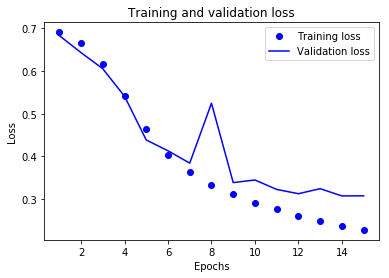

In [0]:
import matplotlib.pyplot as plt
plt.clf()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

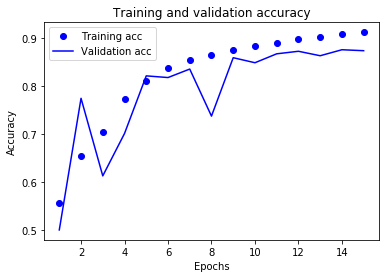

In [0]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Advanced
1. Find some reviews where your model fails to predict the sentiment correctly and give the reason why.
2. Write 5 reviews on your own with at least 20 words. See if your model correctly predicts the sentiment on these reviews


In [0]:
def accuracy(x_strat, y_strat, model):

    acc = model.evaluate(x_strat, y_strat)[1]
    return acc

acc = accuracy(x_test, y_test, model)
print('Test accuracy is, ', acc*100, '%')

25000/25000 [==============================] - 3s 119us/step
Test accuracy is,  87.044 %


# A list of  5 comments written by me to validate the model parameters

In [0]:
a = ['this movie is disaster in the history of Bollywood. i never expected this from such a great actor and movie maker.', 'this movie is filled with awful moments and i am very depressed after watching this movie.', 'what a great movie i loved it so much acting is great by a great actor and the makers have done a good job. they have put a lot of effort in this.', 'this movie is total worth watching, good comedy movie i have seen ever some laughing scenes are not that good but over all the movie is very good.', 'these kinds of movies comes in once in ceturies. a must watch movie, full of enjoyment, very much loved by teeagers']

In [0]:
print(len(a))

5


In [0]:
b =[]
for i in a:
    c = []
    for j in i.split():
    try:
        c.append(word_to_id[j])
    except:
        pass
    b.append(c)

In [0]:
b = np.array(b)

In [0]:
b

array([list([11, 17, 6, 1687, 8, 1, 476, 4, 10, 112, 870, 11, 36, 138, 3, 84, 281, 2, 17]),
       list([11, 17, 6, 1058, 16, 370, 385, 2, 10, 241, 52, 4336, 100, 146, 11]),
       list([48, 3, 84, 17, 10, 444, 9, 35, 73, 113, 6, 84, 31, 3, 84, 281, 2, 1, 1185, 25, 221, 3, 49, 33, 25, 273, 3, 173, 4, 778, 8]),
       list([11, 17, 6, 961, 287, 49, 209, 17, 10, 25, 107, 123, 46, 1101, 136, 23, 21, 12, 49, 18, 117, 29, 1, 17, 6, 52]),
       list([131, 2569, 4, 99, 263, 8, 277, 8, 3, 212, 103, 365, 4, 52, 73, 444, 31])],
      dtype=object)

In [0]:
validation = multi_hot_encode(b, 10000)

In [0]:
print(validation)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
print('Negative, positive')
print(model.predict(validation))

array([[0.80785096, 0.19214901],
       [0.7696906 , 0.23030943],
       [0.42512083, 0.57487917],
       [0.18588467, 0.81411535],
       [0.29561648, 0.70438355]], dtype=float32)